In [ ]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

#生成一个人造数据集
def synthetic_data(w,b,num_examples):
    X=torch.normal(0,1,(num_examples,len(w)))#X是均值为0，方差为1的随机数，X为n行w列的随机数
    y=torch.matmul(X,w)+b #y=Xw+b
    y+=torch.normal(0,0.01,y.shape) #y=Xw+b+随机噪音
    return X,y.reshape((-1,1)) #y作为列向量返回

#定义真实的w、b，然后利用此函数生成一个训练样本
t_w=torch.tensor([2,-3.4])
t_b=4.2
features,labels=synthetic_data(t_w,t_b,1000)

#X/features:1000行2列的矩阵
#y/label:1000行1列的向量
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([-1.5706, -0.6998]) 
label: tensor([3.4348])


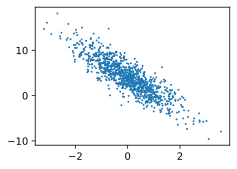

In [2]:
d2l.set_figsize()
#用于设置随后创建的图形的大小,set_figsize 函数通常接受两个参数
#d2l.set_figsize(6, 4) 会设置图形的大小为 6x4 英寸,如果不提供任何参数，使用默认大小

d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)
#最后的1表示绘制的点的大小为1

In [4]:
#读取小批量样本
def data_iter(batch_size,features,labels):
    n=len(features)
    indices=list(range(n))#创建一个从 0 到 n- 1 的索引列表，这个列表将用于随机访问样本
    random.shuffle(indices)#使用 random.shuffle 函数随机打乱索引列表

    #一般情况下，都是拿出i~i+batch_size这个范围内的下标
    #min()是为了处理最后一个批量拿不满batch_size个的情况
    #取出这样一组下标后，生成张量，赋值给batch_indices
    for i in range(0,n,batch_size):
        batch_indices=torch.tensor(indices[i:min(i+batch_size,n)])
        yield features[batch_indices],labels[batch_indices]

#使用 yield 关键字返回当前批次的特征和标签
# yield 使得 data_iter 成为一个生成器函数，每次调用时返回下一个批次的数据
# 而不是一次性返回所有数据。这种按需生成数据的方式可以节省内存。

batch_size=10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[-0.9127, -1.8497],
        [-1.7061, -0.9791],
        [-0.2575,  0.8302],
        [-0.8818, -0.0139],
        [ 0.4865,  1.5904],
        [ 0.3701,  1.8265],
        [ 1.2311,  1.6119],
        [-0.6965,  0.6887],
        [-1.1087, -1.2124],
        [ 0.4026,  0.5380]]) 
 tensor([[ 8.6244],
        [ 4.2232],
        [ 1.0717],
        [ 2.5951],
        [-0.2144],
        [-1.1591],
        [ 1.2284],
        [ 0.2791],
        [ 6.0616],
        [ 3.1065]])


In [5]:
#开始构建模型
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)
def linear(X,w,b):
    return torch.matmul(X,w)+b

#定义损失函数
def squared_loss(y_hat,y):
    return (y_hat-y.reshape(y_hat.shape))**2/2

#定义优化算法
#使用 torch.no_grad() 上下文管理器,这个上下文管理器告诉 PyTorch 在其内部代码块中不需要计算梯度
# 这是因为参数更新不涉及梯度计算，这样做可以节省内存并提高性能
def sgd(params,lr,batch_size):
    with torch.no_grad():
        for param in params:
            param-=lr*param.grad/batch_size
            param.grad.zero_()


In [ ]:
lr=0.03 #定义超参数：学习率
num_epochs=3 #一共进行三轮训练
net=linear #方便后面替换其他的模型
loss=squared_loss 

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l=loss(net(X,w,b),y)
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l=loss(net(features,w,b),labels)
        print(f'epoch {epoch+1},loss {float(train_l.mean()):f}')

epoch 1,loss 0.052071
epoch 2,loss 0.005246
epoch 3,loss 0.005076


In [ ]:
print(f'w的估计误差:{t_w-w.reshape(t_w.shape)}')
print(f'b的估计误差:{t_b-b}')
#从运行结果可以看出误差确实蛮小的

w的估计误差:tensor([ 0.0014, -0.0019], grad_fn=<SubBackward0>)
b的估计误差:tensor([0.0015], grad_fn=<RsubBackward1>)
